# Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calculations

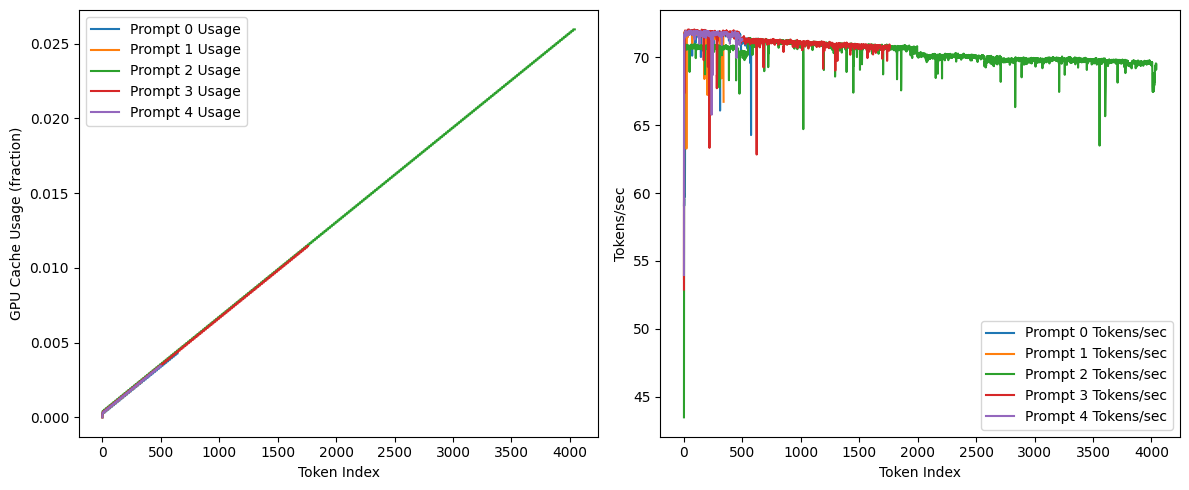

In [5]:
# List of CSV filenames
filenames = [f'kvcache_usage_{i}.csv' for i in range(1, 6)]

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)  # Usage plot
ax2 = plt.subplot(1, 2, 2)  # Tokens/sec plot

for i in range(len(filenames)):
    df = pd.read_csv(filenames[i])
    timestamps = df['timestamp'].values
    usage = df['gpu_cache_usage_sys'].values

    # Compute tokens per second by taking differences of timestamps
    # Avoid division by zero by ensuring no time diff is 0.
    time_diffs = np.diff(timestamps)
    tokens_per_sec = 1.0 / time_diffs

    ax1.plot(usage, label=f'Prompt {i} Usage')
    ax2.plot(tokens_per_sec, label=f'Prompt {i} Tokens/sec')

ax1.set_xlabel('Token Index')
ax1.set_ylabel('GPU Cache Usage (fraction)')
ax1.legend()
ax2.set_xlabel('Token Index')
ax2.set_ylabel('Tokens/sec')
ax2.legend()

plt.tight_layout()
plt.show()